In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [2]:
cr_loan_prep = pd.read_csv('cr_loan_w2.csv')

# Gradient boosted trees with XGBoost

## Trees for defaults

In [3]:
# Set the dataset for training
X = cr_loan_prep.drop('loan_status', axis=1)
y = cr_loan_prep[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [4]:
# Train a model
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict with a model
gbt_preds = clf_gbt.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(gbt_preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

   loan_status  prob_default
0            1      0.990942
1            1      0.983987
2            0      0.000807
3            0      0.001239
4            1      0.084892


## Gradient boosted portfolio performance

In [11]:
portfolio = pd.read_csv('portfolio_2.csv')

In [12]:
# Print the first five rows of the portfolio data frame
print(portfolio.head())

# Create expected loss columns for each model using the formula
portfolio['gbt_expected_loss'] = portfolio['gbt_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']
portfolio['lr_expected_loss'] = portfolio['lr_prob_default'] * portfolio['lgd'] * portfolio['loan_amnt']

# Print the sum of the expected loss for lr
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss']))

# Print the sum of the expected loss for gbt
print('GBT expected loss: ', np.sum(portfolio['gbt_expected_loss']))


   Unnamed: 0  gbt_prob_default  lr_prob_default  lgd  loan_amnt
0           0          0.991000            0.446  0.2      15000
1           1          0.984000            0.223  0.2      11200
2           2          0.000807            0.289  0.2      15000
3           3          0.001240            0.169  0.2      10800
4           4          0.084900            0.114  0.2       3000
LR expected loss:  5597617.784933953
GBT expected loss:  5384466.7748106


It looks like the total expected loss for the XGBClassifier() model is quite a bit lower. When we talk about accuracy and precision, the goal is to generate models which have a low expected loss. Looking at a classification_report() helps as well.

## Assessing graadient boosted trees

In [6]:
# Predict the labels for loan status
gbt_preds = clf_gbt.predict(X_test)

# Check the values created by the predict method
print(gbt_preds)

# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

[1 1 0 ... 0 0 0]
              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9198
     Default       0.94      0.74      0.83      2586

    accuracy                           0.93     11784
   macro avg       0.94      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784



The recall for defaults is 0.74 which is meaning that 74% of our true defaults were predicted correctly.
Compating with 27% which generating by logistic regression.

# Columns selection for credit risk

## Column importance and default prediction

In [14]:
X = cr_loan_prep[['person_income','loan_int_rate',
                  'loan_percent_income','loan_amnt',
                  'person_home_ownership_MORTGAGE','loan_grade_F']]
y = cr_loan_prep[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [15]:
# Create and train the model on the training data
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# Print the column importances from the model
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

{'person_income': 1299.0, 'loan_int_rate': 1001.0, 'loan_percent_income': 515.0, 'loan_amnt': 519.0, 'person_home_ownership_MORTGAGE': 116.0, 'loan_grade_F': 9.0}


So, the importance for loan_grade_F is only 9 in this case. This could be because there are so few of the F-grade loans. While the F-grade loans don't add much to predictions here, they might affect the importance of other training columns.

## Visualizing column importance

In [16]:
X2 = cr_loan_prep[['loan_int_rate','person_emp_length']]

In [17]:
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.4, random_state=123)

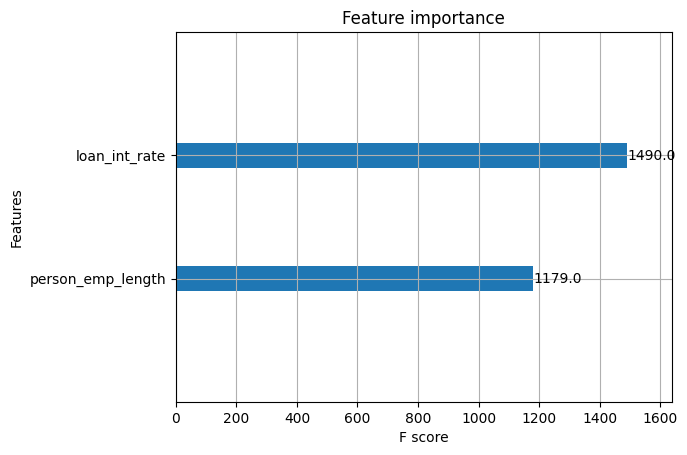

In [26]:
# Train a model on the X data with 2 columns
clf_gbt2 = xgb.XGBClassifier().fit(X2_train,np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt2, importance_type = 'weight')
plt.show()

In [27]:
X3 = cr_loan_prep[['person_income','loan_int_rate','loan_percent_income']]

In [28]:
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.4, random_state=123)

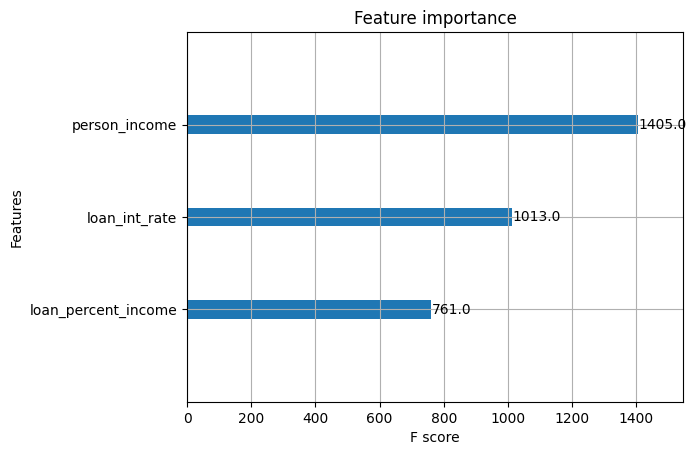

In [29]:
# Train a model on the X data with 3 columns
clf_gbt3 = xgb.XGBClassifier().fit(X3_train,np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt3, importance_type = 'weight')
plt.show()

Take a closer look at the plots. Did you notice that the importance of loan_int_rate went from 1490 to 1013? Initially, this was the most important column, but person_income ended up taking the top spot here.

## Columns selection and model performance

In [32]:
gbt_preds = clf_gbt.predict(X_test)
gbt2_preds = clf_gbt2.predict(X2_test)

# Print the classification report of the first model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

# Print the classification report of the second model
print(classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.91      0.95      0.93      9198
     Default       0.81      0.66      0.73      2586

    accuracy                           0.89     11784
   macro avg       0.86      0.81      0.83     11784
weighted avg       0.89      0.89      0.89     11784

              precision    recall  f1-score   support

 Non-Default       0.83      0.96      0.89      9198
     Default       0.67      0.29      0.40      2586

    accuracy                           0.81     11784
   macro avg       0.75      0.62      0.65     11784
weighted avg       0.79      0.81      0.78     11784



# Cross validation for credit models

In [33]:
X = cr_loan_prep[['person_age', 'person_income', 'person_emp_length', 'loan_int_rate', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N', 'cb_person_default_on_file_Y']]
y = cr_loan_prep[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [34]:
# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10

# Set any specific parameters for cross validation 
params = {'objective': 'binary:logistic', 'seed': 99, 'eval_metric': 'auc'}

# Create the DTrain matrix for XGBoost
Dtrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
cv_df = xgb.cv(params, Dtrain, num_boost_round = 10, nfold = n_folds, early_stopping_rounds = early_stopping)

# Print the cross validations data frame
print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.824139       0.002134       0.813102      0.005004
1        0.832486       0.001611       0.819728      0.004825
2        0.837983       0.001041       0.822616      0.006074
3        0.841160       0.001387       0.823790      0.005584
4        0.843804       0.001749       0.825155      0.004928
5        0.846650       0.001473       0.825610      0.005262
6        0.849336       0.001242       0.826797      0.004909
7        0.852328       0.001558       0.827725      0.005004
8        0.855774       0.001249       0.828406      0.004576
9        0.858327       0.001064       0.829089      0.004715


Do you see how the AUC for both train-auc-mean and test-auc-mean improves at each iteration of cross-validation? As the iterations progress the scores get better, but will they eventually reach 1.0?

## Limits to cross-validation testing

In [36]:
cv = xgb.cv(params, Dtrain, num_boost_round = 600, nfold=10, shuffle = True)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.823531       0.001326       0.813881      0.010226
1        0.830615       0.001646       0.819414      0.009140
2        0.836870       0.001217       0.822950      0.009343
3        0.840156       0.001704       0.824336      0.008814
4        0.842794       0.001452       0.825873      0.008462
0.8339330717971966


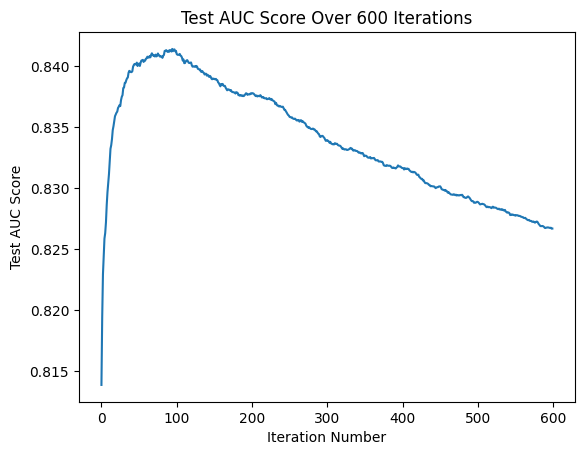

In [37]:
# Print the first five rows of the CV results data frame
print(cv.head())

# Calculate the mean of the test AUC scores
print(np.mean(cv['test-auc-mean']))

# Plot the test AUC scores for each iteration
plt.plot(cv['test-auc-mean'])
plt.title('Test AUC Score Over 600 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

Notice that the test AUC score never quite reaches 1.0 and begins to decrease slightly after 100 iterations. This is because this much cross-validation can actually cause the model to become overfit. So, there is a limit to how much cross-validation you should to.

## Cross-validation scoring

In [38]:
# Create a gradient boosted tree model using two hyperparameters
gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7)

# Calculate the cross validation scores for 4 folds
cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 4)

# Print the cross validation scores
print(cv_scores)

# Print the average accuracy and standard deviation of the scores
print("Average accuracy: %0.2f (+/- %0.2f)" % (np.mean(cv_scores), np.std(cv_scores) * 2))

[0.84068794 0.84091423 0.8427246  0.83227705]
Average accuracy: 0.84 (+/- 0.01)


With only a couple of hyperparameters and cross-validation, we can get the average accuracy up to 84%. This is a great way to validate how robust the model is.

# Class imbalance in loan data

## Undersampling training data

In [39]:
y_train['loan_status'].value_counts()

0    13798
1     3877
Name: loan_status, dtype: int64

In [40]:
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

In [41]:
# Create data sets for defaults and non-defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

0    3877
1    3877
Name: loan_status, dtype: int64


Now, our training set has an even number of defaults and non-defaults. Let's test out some machine learning models on this new undersampled data set and compare their performance to the models trained on the regular data set.

## Undersample tree performance

In [42]:
# Check the classification reports
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))
print(classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.91      0.95      0.93      9198
     Default       0.81      0.66      0.73      2586

    accuracy                           0.89     11784
   macro avg       0.86      0.81      0.83     11784
weighted avg       0.89      0.89      0.89     11784

              precision    recall  f1-score   support

 Non-Default       0.83      0.96      0.89      9198
     Default       0.67      0.29      0.40      2586

    accuracy                           0.81     11784
   macro avg       0.75      0.62      0.65     11784
weighted avg       0.79      0.81      0.78     11784



In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
# Print the confusion matrix for both old and new models
print(confusion_matrix(y_test,gbt_preds))
print(confusion_matrix(y_test,gbt2_preds))

[[8784  414]
 [ 872 1714]]
[[8832  366]
 [1837  749]]


In [45]:
from sklearn.metrics import roc_auc_score

In [46]:
# Print and compare the AUC scores of the old and new models
print(roc_auc_score(y_test, gbt_preds))
print(roc_auc_score(y_test, gbt2_preds))

0.8088949529530529
0.6249226226421662


Undersampling the training data results in more false positives, but the recall for defaults and the AUC score are both higher than the original model. This means overall it predicts defaults much more accurately.

The test set represents the type of data that will be seen by the model in the real world, so changing it would test the model on unrealistic data.